In [1]:
# Necessary imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Setting plot style for better visualization
sns.set_theme(style="whitegrid")

# Directory containing CSV files
data_directory = 'data_2013/2013'

# Function to load and concatenate datasets
def load_and_concatenate(directory):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):  # Make sure to load only CSV files
            file_path = os.path.join(directory, filename)
            current_df = pd.read_csv(file_path)
            df_list.append(current_df)
    full_df = pd.concat(df_list, ignore_index=True)
    return full_df


In [3]:
# Loading dataset
df = load_and_concatenate(data_directory)

# Preprocessing the DataFrame (dropping all-null columns, filtering failed HDDs)
df = df.loc[:, ~df.isnull().all()]
failed_hdds = df.loc[df.failure == 1]["serial_number"]
df = df.loc[df["serial_number"].isin(failed_hdds)]

# Calculating Remaining Useful Life (RUL)
df["end_date"] = df.groupby("serial_number")["date"].transform("max")
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])
df["date_diff"] = (df["end_date"] - df["date"]).dt.days


In [4]:

# Define the prediction horizon (in days)
prediction_horizon = 15

# Create the binary labels based on the prediction horizon
df['will_fail'] = (df['date_diff'] <= prediction_horizon).astype(int)

# Drop unnecessary columns
df = df.drop(['date', 'serial_number', 'model', 'end_date', 'date_diff', 'failure'], axis=1)

# Split the data into features and target
X = df.drop("will_fail", axis=1)
y = df["will_fail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:


# Train a Gradient Boosting Classifier
GB_classifier = GradientBoostingClassifier(random_state=1)
GB_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = GB_classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# Predict the probability of failure within the prediction horizon for the test set
probabilities = GB_classifier.predict_proba(X_test)[:, 1]


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93     12850
           1       0.81      0.16      0.26      2073

    accuracy                           0.88     14923
   macro avg       0.84      0.57      0.60     14923
weighted avg       0.87      0.88      0.84     14923

Confusion Matrix:
 [[12772    78]
 [ 1751   322]]
AUC-ROC: 0.5746302000334108


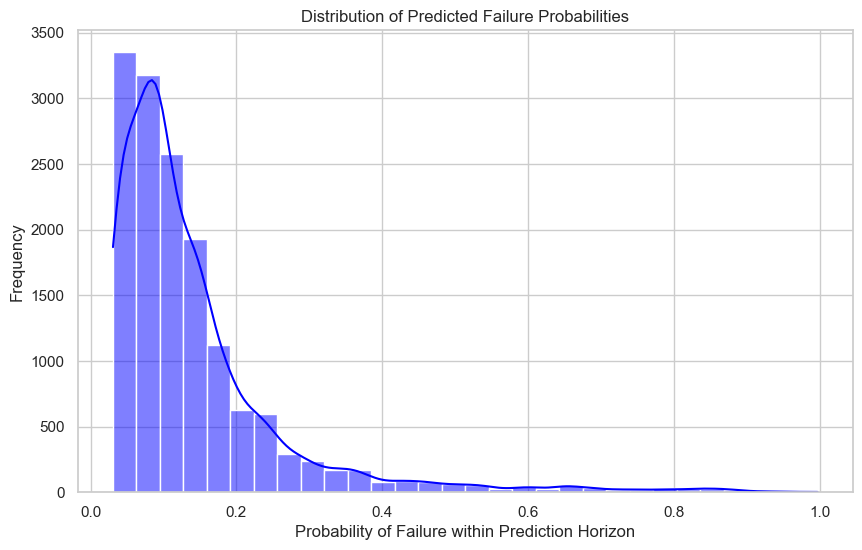

In [6]:
# Visualize the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(probabilities, kde=True, bins=30, color="blue")
plt.title("Distribution of Predicted Failure Probabilities")
plt.xlabel("Probability of Failure within Prediction Horizon")
plt.ylabel("Frequency")
plt.show()


In [7]:


# Flag HDDs for maintenance based on a defined probability threshold
threshold = 0.5  # Example threshold for classification
predictions = (probabilities >= threshold).astype(int)
flagged_hdds = np.where(predictions == 1)[0]
print("Flagged HDDs for maintenance:", flagged_hdds)


Flagged HDDs for maintenance: [    1   146   176   199   217   232   277   294   297   379   436   442
   449   516   532   581   588   697   708   723   748   850   863   888
   909   911   923  1000  1017  1024  1027  1100  1109  1139  1147  1166
  1212  1219  1223  1225  1233  1243  1303  1368  1412  1473  1476  1481
  1510  1517  1525  1549  1581  1591  1613  1636  1715  1730  1762  1829
  1908  2058  2152  2217  2249  2262  2349  2419  2491  2539  2575  2576
  2577  2596  2669  2708  2894  2956  2991  2998  3040  3047  3118  3131
  3159  3231  3242  3340  3507  3523  3580  3619  3635  3665  3695  3728
  3752  3916  3987  4040  4070  4072  4080  4147  4179  4237  4344  4398
  4423  4480  4482  4538  4546  4591  4597  4610  4628  4661  4662  4676
  4736  4799  4921  4969  4987  5019  5035  5077  5107  5138  5164  5183
  5190  5403  5433  5482  5513  5527  5549  5557  5582  5618  5631  5672
  5673  5713  5757  5779  5805  5827  5851  5858  5977  5995  6028  6068
  6077  6079  6125  6